In [105]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import kabuki
import seaborn as sns
%matplotlib inline
import hddm
print(hddm.__version__)
sns.set_theme()

0.8.0


In [5]:
def read_models(filepath, n_chains=4):
    models=[]
    for i in range(n_chains):    
        models.append(hddm.load(f'{filepath}_{i}model'))
    return kabuki.utils.concat_models(models)

In [6]:
def hdi(ary, hdi_prob):
    """Compute hpi over the flattened array."""
    ary = ary.flatten()

    n = len(ary)


    ary = np.sort(ary)
    interval_idx_inc = int(np.floor(hdi_prob * n))
    n_intervals = n - interval_idx_inc
    interval_width = np.subtract(ary[interval_idx_inc:], ary[:n_intervals], dtype=np.float_)

    if len(interval_width) == 0:
        raise ValueError("Too few elements for interval calculation. ")

    min_idx = np.argmin(interval_width)
    hdi_min = ary[min_idx]
    hdi_max = ary[min_idx + interval_idx_inc]

    hdi_interval = np.array([hdi_min, hdi_max])

    return hdi_interval

In [115]:
def extract_params(model, contains=None):
    stats = model.gen_stats()
    if contains is not None:
        out = stats[stats.index.str.contains(contains,na=False)]
    else:
        out = stats
    return out 

def ttests(model_hia, model_loa, params=['a','t','v','z'], trials='101'):

    for param in params:
        hia = extract_params(model_hia, f'{param}_subj\({trials}\)')
        loa = extract_params(model_loa, f'{param}_subj\({trials}\)')
        h,p = scipy.stats.ttest_ind(hia['mean'], loa['mean'])
        print(f't-test {param} {trials} - p = {p:.4f} - t = {h:.4f}')

def compute_hdi(hia_101, loa_101, hia_102, loa_102, parameter_name, interval=0.95):
    hdi_hia_101 = hdi(hia_101.trace(), interval)
    hdi_loa_101 = hdi(loa_101.trace(), interval)

    hdi_diff_101 = hdi(hia_101.trace() - loa_101.trace(), interval)

    hdi_hia_102 = hdi(hia_102.trace(), interval)
    hdi_loa_102 = hdi(loa_102.trace(), interval)

    hdi_diff_102 = hdi(hia_102.trace() - loa_102.trace(), interval)

    print('mixed gamble')
    print(f'{parameter_name} {interval} HDI high anx = {hdi_hia_101}')
    print(f'{parameter_name} {interval} HDI low anx = {hdi_loa_101}')
    print(f'{parameter_name} {interval} HDI difference = {hdi_diff_101}')
    print()
    print('gain only')
    print(f'{parameter_name} {interval} HDI high anx = {hdi_hia_102}')
    print(f'{parameter_name} {interval} HDI low anx = {hdi_loa_102}')
    print(f'{parameter_name} {interval} HDI difference = {hdi_diff_102}')

def probabilities(hia_101, loa_101, hia_102, loa_102, parameter_name):
    print(f"{parameter_name} mixed-gamble P(High Anx > Low Anx) = {(hia_101.trace() > loa_101.trace()).mean():.3f}")
    print(f"{parameter_name} gain-only P(High Anx > Low Anx) = {(hia_102.trace() > loa_102.trace()).mean():.3f}")
    print()

def plot_posteriors(hia_101, loa_101, hia_102, loa_102, parameter_name):
    hddm.analyze.plot_posterior_nodes([hia_101, loa_101])
    plt.xlabel(f'{parameter_name}')
    plt.ylabel('Posterior probability')
    plt.title(f'Posterior of {parameter_name} group means - mixed gamble')
    plt.legend(['high anx', 'low anx'])
    plt.show()

    hddm.analyze.plot_posterior_nodes([hia_102, loa_102])
    plt.xlabel(f'{parameter_name}')
    plt.ylabel('Posterior probability')
    plt.title(f'Posterior of {parameter_name} group means - gain only')
    plt.legend(['high anx', 'low anx'])
    plt.show()





# def ttests(model_hia, model_loa, params=['a','t','v','z'], trials='101'):

#     for param in params:
#         hia = extract_params(model_hia, f'{param}_subj\({trials}\)')
#         loa = extract_params(model_loa, f'{param}_subj\({trials}\)')
#         h,p = scipy.stats.ttest_ind(hia['mean'], loa['mean'])
#         print(f't-test {param} {trials} - p = {p:.4f} - t = {h:.4f}')

# def extract_params(model, contains=None):
#     stats = model.gen_stats()
#     if contains is not None:
#         out = stats[stats.index.str.contains(contains,na=False)]
#     else:
#         out = stats
#     return out 




def extract_params(model, params=['a','t','v','z'], trials='101'):
    df = pd.DataFrame(columns=params)
    for param in params:
        stats = model.gen_stats()
        tmp = stats[stats.index.str.contains(f'{param}_subj\({trials}\)',na=False)]['mean'].to_frame()
        tmp.rename(index=lambda Index: Index[-1], inplace=True)
        df[param] = tmp['mean']
    return df.astype(float)

def correlations(sim, est, param):
    h,p = scipy.stats.pearsonr(sim[param], est[param])
    print(f'corr {param} : r = {h:.4f} - p = {p:.4f} ')

In [8]:
model_loa = read_models('./atvz_par_rec_loa_4c_4000s_1000b', n_chains=4)
model_hia = read_models('./atvz_par_rec_hia_4c_4000s_1000b', n_chains=4)

In [59]:
sim_hia_params_101 = pd.read_csv('./params_hia_101.csv', delimiter=',', header=0, names=['a','t','v','z'])
sim_hia_params_102 = pd.read_csv('./params_hia_102.csv', delimiter=',', header=0, names=['a','t','v','z'])
sim_loa_params_101 = pd.read_csv('./params_loa_101.csv', delimiter=',', header=0, names=['a','t','v','z'])
sim_loa_params_102 = pd.read_csv('./params_loa_102.csv', delimiter=',', header=0, names=['a','t','v','z'])

In [72]:
est_hia_params_101 = extract_params(model_hia, params=['a','t','v','z'], trials='101')
est_hia_params_102 = extract_params(model_hia, params=['a','t','v','z'], trials='102')

est_loa_params_101 = extract_params(model_loa, params=['a','t','v','z'], trials='101')
est_loa_params_102 = extract_params(model_loa, params=['a','t','v','z'], trials='102')

In [116]:
print('High Anxiety - Mixed-gamble')
correlations(sim_hia_params_101, est_hia_params_101, 'a')
correlations(sim_hia_params_101, est_hia_params_101, 't')
correlations(sim_hia_params_101, est_hia_params_101, 'v')
correlations(sim_hia_params_101, est_hia_params_101, 'z')
print()
print('High Anxiety - Gain-only')
correlations(sim_hia_params_102, est_hia_params_102, 'a')
correlations(sim_hia_params_102, est_hia_params_102, 't')
correlations(sim_hia_params_102, est_hia_params_102, 'v')
correlations(sim_hia_params_102, est_hia_params_102, 'z')
print()
print('Low Anxiety - Mixed-gamble')
correlations(sim_loa_params_101, est_loa_params_101, 'a')
correlations(sim_loa_params_101, est_loa_params_101, 't')
correlations(sim_loa_params_101, est_loa_params_101, 'v')
correlations(sim_loa_params_101, est_loa_params_101, 'z')
print()
print('Low Anxiety - Gain-only')
correlations(sim_loa_params_102, est_loa_params_102, 'a')
correlations(sim_loa_params_102, est_loa_params_102, 't')
correlations(sim_loa_params_102, est_loa_params_102, 'v')
correlations(sim_loa_params_102, est_loa_params_102, 'z')

High Anxiety - Mixed-gamble
corr a : r = 0.5090 - p = 0.0001 
corr t : r = 0.8589 - p = 0.0000 
corr v : r = 0.5516 - p = 0.0000 
corr z : r = 0.2496 - p = 0.0687 

High Anxiety - Gain-only
corr a : r = 0.0664 - p = 0.6335 
corr t : r = 0.6557 - p = 0.0000 
corr v : r = 0.3397 - p = 0.0120 
corr z : r = 0.4125 - p = 0.0019 

Low Anxiety - Mixed-gamble
corr a : r = 0.2788 - p = 0.0295 
corr t : r = 0.8903 - p = 0.0000 
corr v : r = 0.5123 - p = 0.0000 
corr z : r = 0.1354 - p = 0.2980 

Low Anxiety - Gain-only
corr a : r = 0.2114 - p = 0.1019 
corr t : r = 0.8589 - p = 0.0000 
corr v : r = 0.5054 - p = 0.0000 
corr z : r = 0.3486 - p = 0.0059 


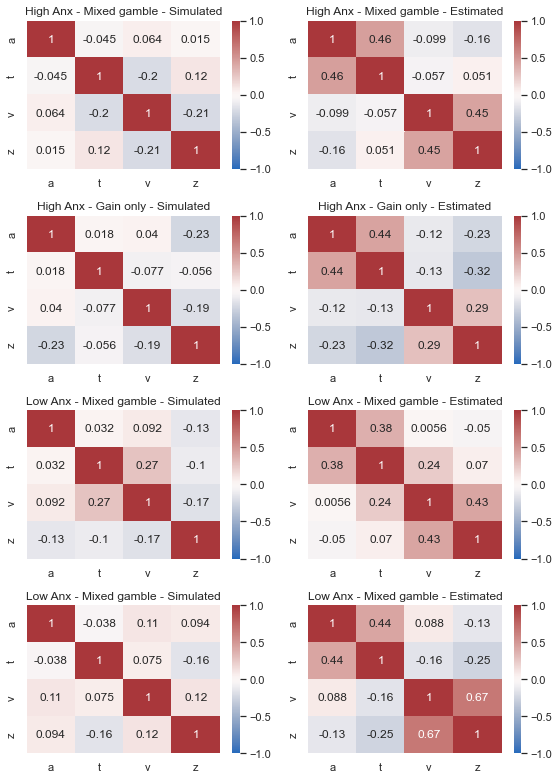

In [127]:
fig, axes = plt.subplots(4, 2, figsize=(8,11))
# fig.suptitle('High Anx - Mixed gamble')
sns.heatmap(sim_hia_params_101.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag', ax=axes[0,0])
sns.heatmap(est_hia_params_101.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag', ax=axes[0,1])
axes[0,0].set_title('High Anx - Mixed gamble - Simulated')
axes[0,1].set_title('High Anx - Mixed gamble - Estimated')
# plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(15,5))
# fig.suptitle('High Anx - Gain only')
sns.heatmap(sim_hia_params_102.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag', ax=axes[1,0])
sns.heatmap(est_hia_params_102.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag', ax=axes[1,1])
axes[1,0].set_title('High Anx - Gain only - Simulated')
axes[1,1].set_title('High Anx - Gain only - Estimated')
# plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(15,5))
# fig.suptitle('Low Anx - Mixed gamble')
sns.heatmap(sim_loa_params_101.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag', ax=axes[2,0])
sns.heatmap(est_loa_params_101.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag', ax=axes[2,1])
axes[2,0].set_title('Low Anx - Mixed gamble - Simulated')
axes[2,1].set_title('Low Anx - Mixed gamble - Estimated')
# plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(15,5))
# fig.suptitle('Low Anx - Gain only')
sns.heatmap(sim_loa_params_102.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag', ax=axes[3,0])
sns.heatmap(est_loa_params_102.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag', ax=axes[3,1])
axes[3,0].set_title('Low Anx - Mixed gamble - Simulated')
axes[3,1].set_title('Low Anx - Mixed gamble - Estimated')
plt.tight_layout()
plt.savefig('./atvz_correlations_recovery.png', dpi=300)
plt.show()